In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

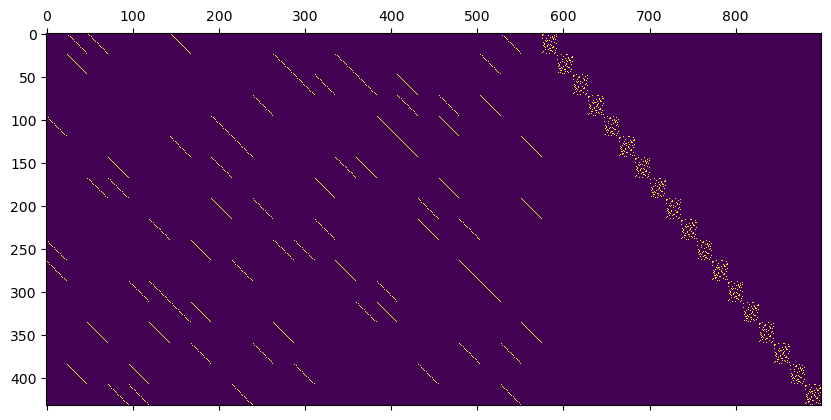

In [26]:
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")

qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")

hgp_qcode = qcode
hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()


qubit_error_rate = 0.02
meas_error_rate = 0.0

stab_type = True
tanner = True if meas_error_rate else False

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz


qec_aug_dec_H = np.hstack([hgp_H, np.eye(hgp_H.shape[0], dtype=int)])
qec_aug_channel_probs = [qubit_error_rate]*hgp_H.shape[1] + [meas_error_rate]*(hgp_H.shape[0])

qec_dec_H = hgp_H
qec_channel_probs = [qubit_error_rate]*hgp_H.shape[1]
L = Lx if stab_type else Lz

plt.matshow(qec_dec_H)


In [27]:
qec_aug_dec = BpDecoder(
    qec_aug_dec_H,
    channel_probs=qec_aug_channel_probs,
    bp_method="ms",
    max_iter=30,
    # osd_method="osd_cs",
    # osd_order=4 #the osd search depth
)

qec_dec = BpOsdDecoder(
    qec_dec_H,
    channel_probs=qec_channel_probs,
    bp_method="ms",
    max_iter=Hx.shape[1],
    osd_method="osd0",
    # osd_order=4 #the osd search depth
)

def decode(curr_synd, augment):
    guessed_error = np.zeros(H.shape[1], dtype=int)

    if (augment):
        guessed_error = qec_aug_dec.decode(curr_synd[qcode.qedzm:])[:H.shape[1]]
    else:
        guessed_error = qec_dec.decode(curr_synd[qcode.qedzm:])

    return guessed_error

In [28]:
# np.random.seed(0)

num_iters = 1000
concat = 1 if qcode.qedxm else 0
# concat = 0
adaptive = 0
successes = 0

qubit_errors = []
synd_errors = []
synd = []

for ii in tqdm(range(1,num_iters+1)):
    curr_qubit_error = np.zeros(H.shape[1], dtype=int)

    success = 1
    for jj in range(10):
        new_qubit_error = np.random.choice([0, 1], size=H.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=H.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error ^= new_qubit_error

        curr_synd = ((H @ curr_qubit_error) % 2) ^ new_synd_error
        guessed_error = decode(curr_synd, tanner)
        curr_qubit_error ^= guessed_error

    curr_synd = ((H @ curr_qubit_error) % 2)
    guessed_error = decode(curr_synd, 0)
    curr_qubit_error ^= guessed_error
    # curr_synd = ((H @ curr_qubit_error) % 2)

    obs = (L @ curr_qubit_error) % 2

    if np.any(obs): # or np.any(curr_synd):
        success = 0
        qubit_errors.append(np.where(new_qubit_error)[0])
        synd_errors.append(np.where(new_synd_error)[0])


    successes += success

print()
print(successes/num_iters)

100%|██████████| 1000/1000 [00:11<00:00, 87.23it/s]


0.965


In [79]:
qubit_errors

[array([43], dtype=int64),
 array([12, 20, 99], dtype=int64),
 array([9], dtype=int64),
 array([ 4, 47, 67], dtype=int64),
 array([21], dtype=int64),
 array([29, 31], dtype=int64),
 array([ 4, 36, 43, 68], dtype=int64),
 array([44], dtype=int64),
 array([45], dtype=int64),
 array([20], dtype=int64),
 array([31, 66], dtype=int64),
 array([45], dtype=int64),
 array([16], dtype=int64),
 array([34, 94], dtype=int64),
 array([42], dtype=int64),
 array([17, 97], dtype=int64),
 array([8], dtype=int64),
 array([42], dtype=int64),
 array([], dtype=int64),
 array([43], dtype=int64),
 array([45], dtype=int64),
 array([40], dtype=int64),
 array([46, 60, 68], dtype=int64),
 array([17], dtype=int64),
 array([40], dtype=int64),
 array([22, 78], dtype=int64),
 array([11, 42], dtype=int64),
 array([18], dtype=int64),
 array([55, 63], dtype=int64),
 array([92], dtype=int64),
 array([23], dtype=int64),
 array([14, 17], dtype=int64),
 array([ 8, 33, 53, 80], dtype=int64),
 array([22], dtype=int64),
 array

In [80]:
synd_errors

[array([31], dtype=int64),
 array([14, 46], dtype=int64),
 array([1, 8], dtype=int64),
 array([], dtype=int64),
 array([ 7, 29, 37], dtype=int64),
 array([13], dtype=int64),
 array([], dtype=int64),
 array([24], dtype=int64),
 array([], dtype=int64),
 array([1], dtype=int64),
 array([ 4, 37, 38], dtype=int64),
 array([], dtype=int64),
 array([23], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0], dtype=int64),
 array([24], dtype=int64),
 array([], dtype=int64),
 array([18, 24, 38, 42], dtype=int64),
 array([34], dtype=int64),
 array([], dtype=int64),
 array([22], dtype=int64),
 array([28], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([24, 25], dtype=int64),
 array([22], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([5], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([ 9, 37], dtype=int64)